In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Carga y preparacion de datos

In [3]:
# Cargar el DataFrame desde el archivo
with open('../Pickles/df_final.pickle', 'rb') as archivo:
    df = pickle.load(archivo)

In [4]:
# Establecer la opción para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [5]:
nombres=df.drop(['CompTotal'], axis=1).columns

In [6]:
df.isnull().values.any()

False

Para comprender mejor la distribución de la variable objetivo 'target' (salario), se ha generado un gráfico de densidad utilizando la función `kdeplot` de la biblioteca `seaborn`. 

El gráfico resultante muestra una *distribución asimétrica positiva*, con una mayor concentración de salarios entre 0 y 100.000 y una cola que se extiende hacia valores más altos, llegando hasta aproximadamente 400.000.

Esta visualización permite extraer las siguientes conclusiones:

- **Asimetría positiva**: La distribución presenta un sesgo hacia la derecha, lo que indica que la mayoría de los salarios son relativamente bajos, mientras que hay una menor proporción de salarios altos.
- **Valores extremos**: La cola derecha extendida sugiere la presencia de valores atípicamente altos que podrían influir en el modelo. Se considerarán estos valores como outliers y se aplicarán técnicas estadísticas para su tratamiento.
- **Concentración de datos**: La mayor densidad se observa en el rango de 0 a 100.000, lo que indica el rango de salarios más común.
- **Valores cercanos a cero**: Se observa una pequeña concentración de valores alrededor de cero, lo que requiere una investigación más profunda para determinar su naturaleza.

Estas observaciones sugieren que podría ser beneficioso aplicar transformaciones a la variable 'target' para reducir la asimetría y mejorar el rendimiento del modelo. Además, se investigará la naturaleza de los valores cercanos a cero y se aplicarán técnicas de detección y tratamiento de outliers a los valores extremos.

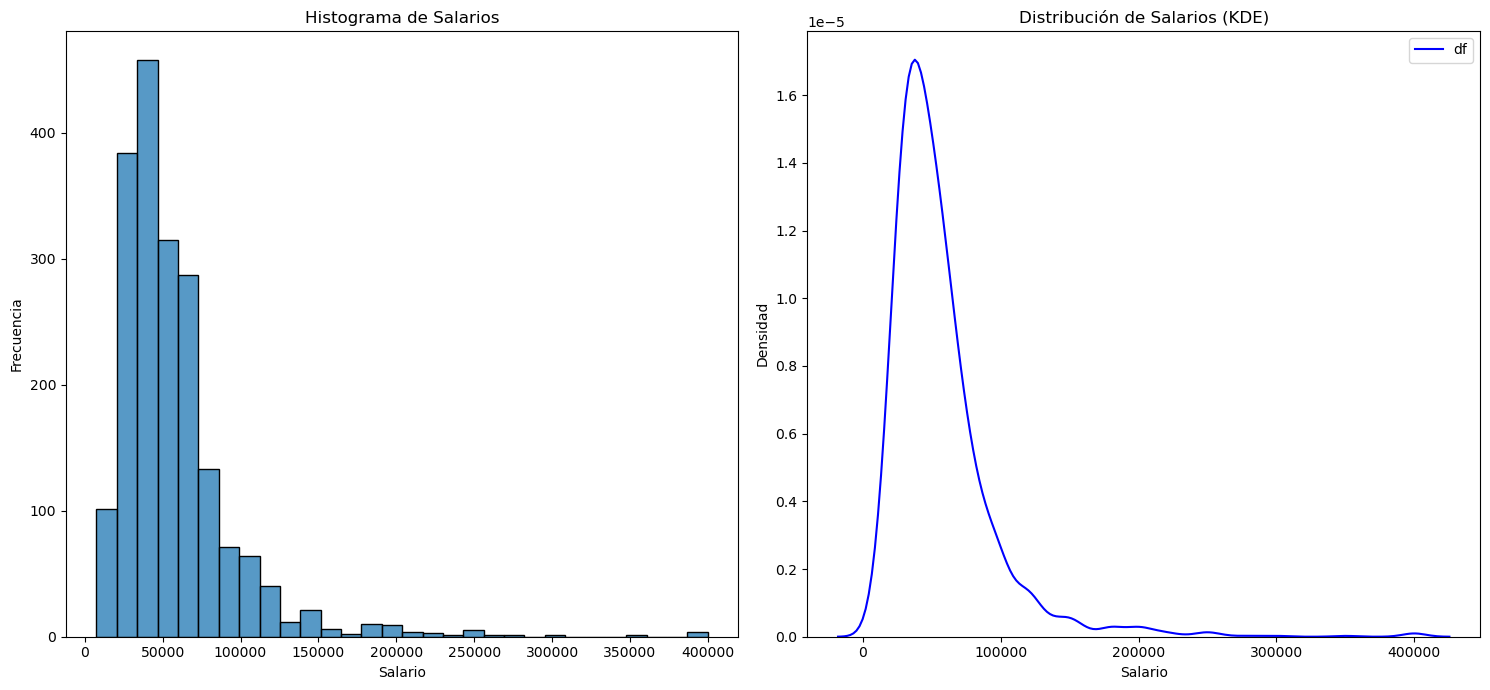

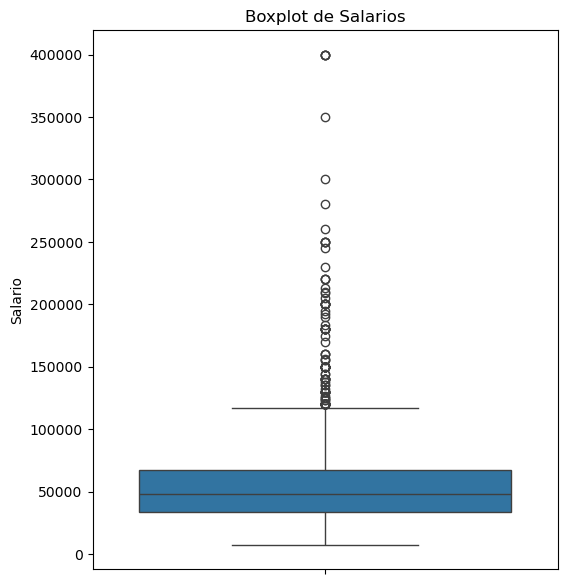

In [7]:
# 1. Histograma y gráfico de densidad
plt.figure(figsize=(15, 7))

# Histograma
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
sns.histplot(df['CompTotal'], kde=False, bins=30)
plt.title('Histograma de Salarios')
plt.xlabel('Salario')
plt.ylabel('Frecuencia')

# KDE Plot
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
sns.kdeplot(df['CompTotal'], label='df', color='blue')
plt.title('Distribución de Salarios (KDE)')
plt.xlabel('Salario')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

# 2. Boxplot
plt.figure(figsize=(6, 7))
sns.boxplot(y=df['CompTotal'])
plt.title('Boxplot de Salarios')
plt.ylabel('Salario')
plt.show()

In [8]:
df.describe()

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

**Conclusión:**
- Tanto el histograma como el KDE plot nos permiten ver que hay una distribución asimetrica positiva, con la mayor parte de los datos concentrados entre 20000 y 80000, y con una cola hacia la derecha.
- El boxplot muestra que hay algunos valores por encima del bigote superior, que podrían considerarse como outliers, como la regla del 1.5xIQR.
___________________________________________________________________________________________________________________

**Filtro y umbrales:**

Para identificar y tratar los valores atípicos en la variable 'target' (salario), se han utilizado las siguientes técnicas:

1) Visualización:
- Se ha generado un histograma y un gráfico de densidad para visualizar la distribución de los salarios.
- Se ha generado un boxplot para identificar visualmente los outliers.
2) Rango Intercuartílico (IQR):
Se ha calculado el IQR y se han considerado outliers los valores fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR], que corresponde a [-16993.75, 117396.25].
3) Percentiles:
Se han utilizado los percentiles 3 y 95 para definir los límites inferior y superior, respectivamente. Los valores fuera del rango [18000.0, 120000.0] se han considerado outliers. 

In [9]:
# 3. IQR
Q1 = df['CompTotal'].quantile(0.25)
Q3 = df['CompTotal'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior_iqr = Q1 - 1.5 * IQR
limite_superior_iqr = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Límite inferior (IQR): {limite_inferior_iqr}")
print(f"Límite superior (IQR): {limite_superior_iqr}")

# 4. Percentiles
percentil_3 = df['CompTotal'].quantile(0.03)
percentil_95 = df['CompTotal'].quantile(0.95)

print(f"Percentil 3: {percentil_3}")
print(f"Percentil 95: {percentil_95}")

# Del boxplot y el IQR, ya podemos identificar algunos outliers.
# Usemos ahora los límites calculados para filtrar el DataFrame

# Filtrar outliers usando IQR
df_filtrado_iqr = df[(df['CompTotal'] >= limite_inferior_iqr) & (df['CompTotal'] <= limite_superior_iqr)]

# Filtrar outliers usando percentiles
df_filtrado_percentiles = df[(df['CompTotal'] >= percentil_3) & (df['CompTotal'] <= percentil_95)]

# Comparar tamaños de los DataFrames
print(f"\nTamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado con IQR: {df_filtrado_iqr.shape}")
print(f"Tamaño del DataFrame filtrado con percentiles: {df_filtrado_percentiles.shape}")

IQR: 33597.5
Límite inferior (IQR): -16993.75
Límite superior (IQR): 117396.25
Percentil 3: 18000.0
Percentil 95: 120000.0

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado con IQR: (1817, 397)
Tamaño del DataFrame filtrado con percentiles: (1801, 397)


**Interpretación y comparación:**

- IQR: Sugiere un límite superior de 117396.25 euros.
- Percentiles: Sugiere el límine superior en 120000 euros (con el percentil 95).

- Elección del límite inferior:
    - El percentil 3 (18000) es concordante con los límites mínimo establecido en el convenio colectivo del sector (17.599,36 para la categoría mínima), por lo que usaré ese mínimo. 
- Elección del límite superior:
    - El IQR da un límite inferior similar (-16993.75) que el percentil 3, aunque por las razones expuestas se utilizará el límite establecido en Conveio colectivo. 
    - Teniendo en cuenta el análisis visual del gráfico de densidad, éste sugiere que la "cola" empieza alrededor de 150,000.
    - Usar 120000 euros como límite superior parece un valor razonable que permite eliminar una buena parte de los outliers, eliminando tan solo el 5% de los datos.

Como resultado del análisis, y como se puede ver en los gráficos, se ha decidido utilizar el método percentil para la eliminación de outliers, ya que proporciona un equilibrio entre la eliminación de valores extremos y la conservación de datos (se eliminan 132 datos, lo que representa un 6.83% de los datos).

La decisión de utilizar este método y este porcentaje de eliminación se basa en la observación de que los valores eliminados se encuentran en las colas de la distribución y su inclusión podría afectar negativamente el rendimiento del modelo.

In [10]:
limite_inferior = 18000
limite_superior = 120000

df_filtrado = df[(df['CompTotal'] >= limite_inferior) & (df['CompTotal'] <= limite_superior)]

print(f"Tamaño del DataFrame original: {df.shape}")
print(f"Tamaño del DataFrame filtrado: {df_filtrado.shape}")

df = df_filtrado

Tamaño del DataFrame original: (1934, 397)
Tamaño del DataFrame filtrado: (1801, 397)


In [11]:
df.describe()

,MainBranch,EdLevel,YearsCode,YearsCodePro,PurchaseInfluence,CompTotal,AISelect,AISent,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Age_Grouped_Adulto,Age_Grouped_Joven,Age_Grouped_Senior,is_full_time,is_part_time,is_independent,num_jobs,is_other_employment,Remote_grouped_In-person,Remote_grouped_Remote/Hybrid,CodingActivities_encoded,LearnCode_encoded,LearnCodeOnline_encoded,DevType_encoded,OrgSize_Grouped_Desconocido,OrgSize_Grouped_Grande,OrgSize_Grouped_Mediana,OrgSize_Grouped_Muy Pequeña,OrgSize_Grouped_Pequeña,Android-based,Linux-based,MacOS,Otros,Windows-based,Industry_Category_Industria y Energía,Industry_Category_Otros Servicios,Industry_Category_Salud y Educación,Industry_Category_Servicios Financieros,Industry_Category_Tecnología y Servicios Digitales,BuyNewTool_Ask a generative AI tool,BuyNewTool_Ask developers I know/work with,BuyNewTool_Other,BuyNewTool_Other (please specify):,BuyNewTool_Read ratings or reviews on third party sites like G2 Crowd,BuyNewTool_Research companies that have advertised on sites I visit,BuyNewTool_Research companies that have emailed me,BuyNewTool_Start a free trial,BuyNewTool_Visit developer communities like Stack Overflow,LanguageHaveWorkedWith_,LanguageHaveWorkedWith_Ada,LanguageHaveWorkedWith_Apex,LanguageHaveWorkedWith_Assembly,LanguageHaveWorkedWith_Bash/Shell (all shells),LanguageHaveWorkedWith_C,LanguageHaveWorkedWith_C#,LanguageHaveWorkedWith_C++,LanguageHaveWorkedWith_Clojure,LanguageHaveWorkedWith_Cobol,LanguageHaveWorkedWith_Crystal,LanguageHaveWorkedWith_Dart,LanguageHaveWorkedWith_Delphi,LanguageHaveWorkedWith_Elixir,LanguageHaveWorkedWith_Erlang,LanguageHaveWorkedWith_F#,LanguageHaveWorkedWith_Fortran,LanguageHaveWorkedWith_GDScript,LanguageHaveWorkedWith_Go,LanguageHaveWorkedWith_Groovy,LanguageHaveWorkedWith_HTML/CSS,LanguageHaveWorkedWith_Haskell,LanguageHaveWorkedWith_Java,LanguageHaveWorkedWith_JavaScript,LanguageHaveWorkedWith_Julia,LanguageHaveWorkedWith_Kotlin,LanguageHaveWorkedWith_Lisp,LanguageHaveWorkedWith_Lua,LanguageHaveWorkedWith_MATLAB,LanguageHaveWorkedWith_Nim,LanguageHaveWorkedWith_OCaml,LanguageHaveWorkedWith_Objective-C,LanguageHaveWorkedWith_PHP,LanguageHaveWorkedWith_Perl,LanguageHaveWorkedWith_PowerShell,LanguageHaveWorkedWith_Prolog,LanguageHaveWorkedWith_Python,LanguageHaveWorkedWith_R,LanguageHaveWorkedWith_Ruby,LanguageHaveWorkedWith_Rust,LanguageHaveWorkedWith_SQL,LanguageHaveWorkedWith_Scala,LanguageHaveWorkedWith_Solidity,LanguageHaveWorkedWith_Swift,LanguageHaveWorkedWith_TypeScript,LanguageHaveWorkedWith_VBA,LanguageHaveWorkedWith_Visual Basic (.Net),LanguageHaveWorkedWith_Zig,LanguageWantToWorkWith_,LanguageWantToWorkWith_Ada,LanguageWantToWorkWith_Apex,LanguageWantToWorkWith_Assembly,LanguageWantToWorkWith_Bash/Shell (all shells),LanguageWantToWorkWith_C,LanguageWantToWorkWith_C#,LanguageWantToWorkWith_C++,LanguageWantToWorkWith_Clojure,LanguageWantToWorkWith_Crystal,LanguageWantToWorkWith_Dart,LanguageWantToWorkWith_Delphi,LanguageWantToWorkWith_Elixir,LanguageWantToWorkWith_Erlang,LanguageWantToWorkWith_F#,LanguageWantToWorkWith_Fortran,LanguageWantToWorkWith_GDScript,LanguageWantToWorkWith_Go,LanguageWantToWorkWith_Groovy,LanguageWantToWorkWith_HTML/CSS,LanguageWantToWorkWith_Haskell,LanguageWantToWorkWith_Java,LanguageWantToWorkWith_JavaScript,LanguageWantToWorkWith_Julia,LanguageWantToWorkWith_Kotlin,LanguageWantToWorkWith_Lisp,LanguageWantToWorkWith_Lua,LanguageWantToWorkWith_MATLAB,LanguageWantToWorkWith_Nim,LanguageWantToWorkWith_OCaml,LanguageWantToWorkWith_Objective-C,LanguageWantToWorkWith_PHP,LanguageWantToWorkWith_Perl,LanguageWantToWorkWith_PowerShell,LanguageWantToWorkWith_Prolog,LanguageWantToWorkWith_Python,LanguageWantToWorkWith_R,LanguageWantToWorkWith_Ruby,LanguageWantToWorkWith_Rust,LanguageWantToWorkWith_SQL,LanguageWantToWorkWith_Scala,LanguageWantToWorkWith_Solidity,LanguageWantToWorkWith_Swift,LanguageWantToWorkWith_TypeScript,LanguageWantToWorkWith_VBA,LanguageWantToWorkWith_Visual Basic (.Net)

**Problema en la Distribución Original:** 

La distribución original de la variable CompTotal presentaba un marcado sesgo positivo (sesgo a la derecha). Esto significa que había una mayor concentración de valores en el extremo inferior del rango salarial, con una cola larga extendiéndose hacia valores más altos. Además, se insinuaba una posible multimodalidad, sugiriendo la presencia de múltiples grupos con diferentes rangos salariales dentro de la distribución. Este tipo de distribución puede ser problemático para muchos algoritmos de machine learning que asumen normalidad o simetría en los datos, pudiendo afectar negativamente al rendimiento del modelo.

*Transformación Aplicada:*

Para abordar los problemas de sesgo y no normalidad, se aplicó una transformación logarítmica a la variable CompTotal. Específicamente, se utilizó la función log1p, que calcula el logaritmo natural de (1 + x), lo cual es útil para manejar valores que pueden ser cero.

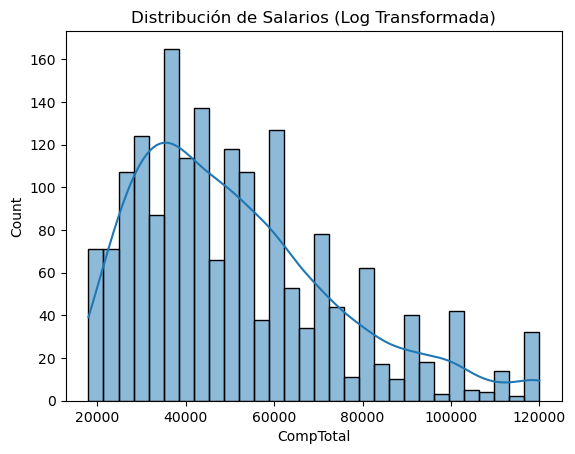

In [12]:
# Target sin transformacion:
sns.histplot(df['CompTotal'], bins=30, kde=True)
plt.title('Distribución de Salarios (Log Transformada)')
plt.show()

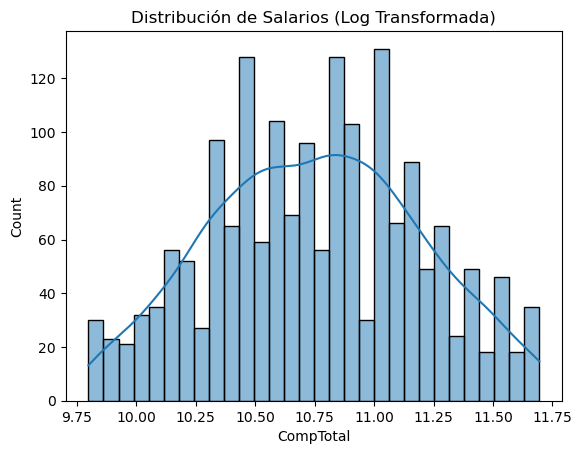

In [13]:
# Target con transformacion logaritmica
df['CompTotal'] = np.log1p(df['CompTotal'])
sns.histplot(df['CompTotal'], bins=30, kde=True)
plt.title('Distribución de Salarios (Log Transformada)')
plt.show()

*Conclusiones:*

La transformación logarítmica ha sido muy efectiva para normalizar la distribución de la variable CompTotal. La distribución transformada es más simétrica, se aproxima más a una distribución normal y es más adecuada para su uso en modelos de machine learning que asumen estas características en los datos. La reducción del sesgo y la mitigación de la multimodalidad son indicadores claros del éxito de la transformación.
________________________________________________________________________________________________

Ya esta todo listo para dividir mis conjuntos de train y test.

In [14]:
y = df['CompTotal']

In [15]:
df = df.drop(columns=['CompTotal'], axis=1)

In [16]:
columnas = df.columns

In [17]:
# --- 1. Dividir los Datos en Entrenamiento, Validación y Prueba ---
X_temp, X_test, y_temp, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1080, 396)
(360, 396)
(361, 396)
(1080,)
(361,)
(360,)


Escalo los datos 

In [19]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
print("X_train - Máximo:", X_train.max())
print("X_train - Mínimo:", X_train.min())
print("X_val - Máximo:", X_val.max())
print("X_val - Mínimo:", X_val.min())

X_train - Máximo: 1.0000000000000002
X_train - Mínimo: 0.0
X_val - Máximo: 1.0000000000000002
X_val - Mínimo: -0.013916500994035824


# Modelos

Empiezo con un Random Forest con los hiperparametros por defecto

In [21]:
# Crear un modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)
# Entrenar el modelo
rf_model.fit(X_train, y_train)

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = rf_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = rf_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)
# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 33843626.779
RMSE: 5817.53
MAE: 3750.827
R2: 0.935
MAPE: 7.16

--- VALIDATION ---
MSE: 228338560.193
RMSE: 15110.88
MAE: 10427.400
R2: 0.570
MAPE: 21.31


Pruebo mejorar los hiperparametros con GridSearch

In [22]:
# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir el espacio de hiperparámetros
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'verbose': [2,0]
}

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # Número de folds para la validación cruzada
    scoring='neg_mean_squared_error',
    n_jobs=-1 # Usar todos los núcleos disponibles
)

# Ajustar el modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_
# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener las características más importantes
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las 300 características más importantes
top_features = indices[:100]
X_train_reduced = X_train[:, top_features]
X_val_reduced = X_val[:, top_features]
X_test_reduced = X_test[:, top_features]

# Reajustar el modelo con las 100 mejores características
best_rf_model.fit(X_train_reduced, y_train)

# Hacer predicciones en los conjuntos de entrenamiento y validación
y_train_pred_log = best_rf_model.predict(X_train_reduced)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_rf_model.predict(X_val_reduced)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("\n--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s


building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79 of 250
building tree 80 of 250
building tree 81 of 250
building tree 82 of 250
building tree 83 of 250
building tree 84 of 250
building tree 85

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.3s


building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250
building tree 178 of 250
building tree 179 of 250
building tree 180 of 250
building tree 181 of 250
building tree 182 of 250
building tree 183 of 250
building tree 184 of 250
building tree 185 of 250
building tree 186 of 250
building tree 187 of 250
building tree 188 of 250
building tree 189 of 250
building tree 190 of 250
building tree 191 of 250
building tree 192 of 250
building tree 193 of 250
building tree 194 of 250
building tree 195 of 250
building tree 196 of 250
building tree 197 of 250
building tree 198 of 250
building tree 199 of 250
building tree 200 of 250
building tree 201 of 250
building tree 202 of 250
building tree 203 of 250
building tree 204 of 250
building tree 205 of 250
building tree 206 of 250
building tree 207 of 250
building tree 208 of 250


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79 of 250
building tree 80 of 250
building tree 81 of 250
building tree 82 of 250
building tree 83 of 250
building tree 84 of 250
building tree 85 of 250
building tree 86 of 250
building tree 87 of 250
building tree 88 of 250
building tree 89

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.4s


building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250
building tree 178 of 250
building tree 179 of 250
building tree 180 of 250
building tree 181 of 250
building tree 182 of 250
building tree 183 of 250
building tree 184 of 250
building tree 185 of 250
building tree 186 of 250
building tree 187 of 250
building tree 188 of 250
building tree 189 of 250
building tree 190 of 250
building tree 191 of 250
building tree 192 of 250
building tree 193 of 250
building tree 194 of 250
building tree 195 of 250
building tree 196 of 250
building tree 197 of 250
building tree 198 of 250
building tree 199 of 250
building tree 200 of 250
building tree 201 of 250
building tree 202 of 250


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [114]:
from sklearn.ensemble import GradientBoostingRegressor
# Crear un modelo de GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gbr_model.fit(X_train, y_train)

# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = gbr_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = gbr_model.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

--- TRAIN ---
MSE: 47714239.768
RMSE: 6907.55
MAE: 5132.710
R2: 0.814
MAPE: 11.67

--- VALIDATION ---
MSE: 127341804.101
RMSE: 11284.58
MAE: 8449.622
R2: 0.524
MAPE: 19.11


In [157]:
# --- Definir el Espacio de Búsqueda de Hiperparámetros ---
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2'],
    'alpha': [0.1, 0.5, 0.9], #parametro de regularizacion L1
    'ccp_alpha': [0.0, 0.01, 0.1] #parametro para la poda
}

# --- Instanciar el Modelo y RandomizedSearchCV ---
gbr = GradientBoostingRegressor(random_state=42, loss='squared_error')  # Usar GradientBoostingRegressor
random_search = RandomizedSearchCV(
    estimator=gbr,  # Cambiar a GradientBoostingRegressor
    param_distributions=param_distributions,
    n_iter=100,  # Número de combinaciones a probar
    cv=3,  # Número de folds en la validación cruzada
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Usar todos los procesadores disponibles
    scoring='neg_mean_squared_error'  # Puedes usar otra métrica si lo prefieres
)

# --- Ajustar RandomizedSearchCV a los Datos ---
random_search.fit(X_train, y_train)

# --- Obtener los Mejores Hiperparámetros y el Mejor Modelo ---
best_params = random_search.best_params_
best_gbr = random_search.best_estimator_
print(best_params)
# --- 3. Hacer Predicciones en los Conjuntos de Entrenamiento y Validación ---
# Entrenamiento
y_train_pred_log = best_gbr.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

# Validación
y_val_pred_log = best_gbr.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# --- 4. Calcular Métricas en la Escala Original ---
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# --- 5. Imprimir Resultados ---
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\emita\.conda\envs\proyecto_ml\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constr

{'subsample': 0.9, 'n_estimators': 450, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.1, 'ccp_alpha': 0.0, 'alpha': 0.1}
--- TRAIN ---
MSE: 7436063.223
RMSE: 2726.91
MAE: 1763.041
R2: 0.986
MAPE: 3.42

--- VALIDATION ---
MSE: 201270381.668
RMSE: 14186.98
MAE: 10516.978
R2: 0.621
MAPE: 21.45


In [158]:
# Obtener las características más importantes
importances = best_gbr.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las 300 características más importantes
top_features = indices[:150]
X_train_reduced = X_train[:, top_features]
X_val_reduced = X_val[:, top_features]
X_test_reduced = X_test[:, top_features]

# Reajustar el modelo con las 100 mejores características
best_gbr.fit(X_train_reduced, y_train)

# Hacer predicciones en los conjuntos de entrenamiento y validación
y_train_pred_log = best_gbr.predict(X_train_reduced)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_gbr.predict(X_val_reduced)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
# Entrenamiento
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

# Validación
mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

# Imprimir resultados
print("\n--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")


--- TRAIN ---
MSE: 2959011.481
RMSE: 1720.18
MAE: 1100.734
R2: 0.994
MAPE: 2.16

--- VALIDATION ---
MSE: 203372912.908
RMSE: 14260.89
MAE: 10598.834
R2: 0.617
MAPE: 22.02


In [159]:
# Definir el modelo base
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

# Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,  # Validación cruzada con 5 particiones
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntaje (MAE):", -grid_search.best_score_)

# Entrenar el modelo final con los mejores parámetros
best_xgb_reg = grid_search.best_estimator_

# Hacer predicciones
y_train_pred_log = best_xgb_reg.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_xgb_reg.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


KeyboardInterrupt: 

In [118]:
# --- Importancia de las Características (si es necesario) ---
feature_importances = best_xgb_reg.feature_importances_

# Paso 1: Obtener importancias de las características y nombres
feature_names = columnas
# Convertir las matrices NumPy a DataFrames de pandas
X_train_df = pd.DataFrame(X_val, columns=feature_names)

# Crear un DataFrame para ordenar las importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
importance_df.head(50)

,Feature,Importance
3,YearsCodePro,0.026630
24,LearnCodeOnline_encoded,0.021145
33,MacOS,0.018032
111,LanguageWantToWorkWith_Erlang,0.015268
20,Remote_grouped_In-person,0.014861
146,DatabaseHaveWorkedWith_BigQuery,0.014153
377,OfficeStackSyncHaveWorkedWith_Slack,0.013535
129,LanguageWantToWorkWith_PHP,0.012922
233,WebframeHaveWorkedWith_jQuery,0.012566
254,MiscTechHaveWorkedWith_OpenGL,0.012312


In [119]:
# Paso 1: Seleccionar las 50 características más importantes
top_features = importance_df['Feature'].head(50).tolist()

# Convertir X_train y X_val a DataFrames (si no lo están ya)
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)

# Filtrar los conjuntos de entrenamiento y validación
X_train_filtered = X_train_df[top_features]
X_val_filtered = X_val_df[top_features]

# Paso 2: Definir el modelo base
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Paso 3: Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],  # Regularización L2
    'reg_alpha': [0.1, 1, 10],   # Regularización L1
    'min_child_weight': [3, 5, 7]
}

# Paso 4: Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,  # Validación cruzada con 3 particiones
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Paso 5: Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_filtered, y_train)

# Imprimir los mejores parámetros y puntaje
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntaje (MAE):", -grid_search.best_score_)

# Paso 6: Entrenar el modelo final con los mejores parámetros
best_xgb_reg = grid_search.best_estimator_

# Hacer predicciones
y_train_pred_log = best_xgb_reg.predict(X_train_filtered)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = best_xgb_reg.predict(X_val_filtered)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

Fitting 3 folds for each of 4374 candidates, totalling 13122 fits


Mejores parámetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.7}
Mejor puntaje (MAE): 0.17441916646027233
--- TRAIN ---
MSE: 62477288.585
RMSE: 7904.26
MAE: 5814.911
R2: 0.756
MAPE: 13.36

--- VALIDATION ---
MSE: 125222917.579
RMSE: 11190.30
MAE: 8244.082
R2: 0.532
MAPE: 18.64


In [120]:
cat = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=100)
cat.fit(X_train, y_train)

# Hacer predicciones
y_train_pred_log = cat.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = cat.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

0:	learn: 0.3579954	total: 8.26ms	remaining: 8.25s
100:	learn: 0.1546223	total: 876ms	remaining: 7.8s
200:	learn: 0.1018885	total: 1.68s	remaining: 6.68s
300:	learn: 0.0706726	total: 2.51s	remaining: 5.83s
400:	learn: 0.0515334	total: 3.32s	remaining: 4.96s
500:	learn: 0.0380616	total: 4.15s	remaining: 4.13s
600:	learn: 0.0296091	total: 4.97s	remaining: 3.3s
700:	learn: 0.0230073	total: 5.77s	remaining: 2.46s
800:	learn: 0.0179927	total: 6.57s	remaining: 1.63s
900:	learn: 0.0137945	total: 7.38s	remaining: 811ms
999:	learn: 0.0104378	total: 8.21s	remaining: 0us
--- TRAIN ---
MSE: 242040.128
RMSE: 491.98
MAE: 336.278
R2: 0.999
MAPE: 0.75

--- VALIDATION ---
MSE: 123337186.117
RMSE: 11105.73
MAE: 8372.263
R2: 0.539
MAPE: 19.12


In [46]:
cat = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=100)
cat.fit(X_train, y_train)

# Hacer predicciones
y_train_pred_log = cat.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_original = np.expm1(y_train)

y_val_pred_log = cat.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_original = np.expm1(y_val)

# Calcular métricas
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100

print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.3f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.2f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.3f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.2f}")

0:	learn: 0.3992170	total: 8.33ms	remaining: 8.32s
100:	learn: 0.1752020	total: 1.21s	remaining: 10.8s
200:	learn: 0.1249336	total: 2.5s	remaining: 9.92s
300:	learn: 0.0902507	total: 3.9s	remaining: 9.06s
400:	learn: 0.0673007	total: 5.26s	remaining: 7.86s
500:	learn: 0.0516169	total: 6.74s	remaining: 6.71s
600:	learn: 0.0402674	total: 8.07s	remaining: 5.36s
700:	learn: 0.0312159	total: 9.16s	remaining: 3.91s
800:	learn: 0.0248412	total: 10.2s	remaining: 2.52s
900:	learn: 0.0195587	total: 11.2s	remaining: 1.23s
999:	learn: 0.0155539	total: 12.2s	remaining: 0us
--- TRAIN ---
MSE: 703622.755
RMSE: 838.82
MAE: 561.664
R2: 0.998
MAPE: 1.14

--- VALIDATION ---
MSE: 139447492.002
RMSE: 11808.79
MAE: 8711.284
R2: 0.662
MAPE: 17.91


In [136]:
# Definir tus mejores modelos
cat = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=100)
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 5, min_child_weight= 5, n_estimators= 100, reg_alpha= 0.1, reg_lambda= 0.1, subsample= 0.8)
gb_model = GradientBoostingRegressor(subsample =0.7, min_samples_split = 5, n_estimators=250, 
                                     learning_rate=0.1, min_samples_leaf = 4,
                                     max_depth=6, random_state=42, loss='squared_error',
                                     ccp_alpha = 0.0, alpha= 0.9)
# Crear el ensemble
voting_regressor = VotingRegressor(estimators=[('cat', cat), ('xgb', xgb_reg), ('gb', gb_model)])

# Ajustar el ensemble al conjunto de entrenamiento
voting_regressor.fit(X_train, y_train)

# Hacer predicciones
y_train_pred_log = voting_regressor.predict(X_train)
y_val_pred_log = voting_regressor.predict(X_val)

# Aplicar transformación inversa
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)

# Obtener los valores originales
y_train_original = np.expm1(y_train)
y_val_original = np.expm1(y_val)

# Calcular métricas en la escala original
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, y_train_pred)
r2_train = r2_score(y_train_original, y_train_pred)
mape_train = np.mean(np.abs((y_train_original - y_train_pred) / y_train_original)) * 100

mse_val = mean_squared_error(y_val_original, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_original, y_val_pred)
r2_val = r2_score(y_val_original, y_val_pred)
mape_val = np.mean(np.abs((y_val_original - y_val_pred) / y_val_original)) * 100


# Imprimir resultados
print("--- TRAIN ---")
print(f"MSE: {mse_train:.3f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R2: {r2_train:.3f}")
print(f"MAPE: {mape_train:.3f}")

print("\n--- VALIDATION ---")
print(f"MSE: {mse_val:.3f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"MAE: {mae_val:.2f}")
print(f"R2: {r2_val:.3f}")
print(f"MAPE: {mape_val:.3f}")

0:	learn: 0.4166606	total: 7.38ms	remaining: 7.37s
100:	learn: 0.1842787	total: 852ms	remaining: 7.58s
200:	learn: 0.1300147	total: 1.66s	remaining: 6.58s
300:	learn: 0.0937319	total: 2.44s	remaining: 5.66s
400:	learn: 0.0692476	total: 3.21s	remaining: 4.79s
500:	learn: 0.0525103	total: 3.99s	remaining: 3.97s
600:	learn: 0.0403412	total: 4.76s	remaining: 3.16s
700:	learn: 0.0316628	total: 5.54s	remaining: 2.37s
800:	learn: 0.0249357	total: 6.33s	remaining: 1.57s
900:	learn: 0.0193337	total: 7.12s	remaining: 782ms
999:	learn: 0.0152737	total: 7.91s	remaining: 0us
--- TRAIN ---
MSE: 11739457.007
RMSE: 3426.29
MAE: 2312.57
R2: 0.977
MAPE: 4.367

--- VALIDATION ---
MSE: 190126526.099
RMSE: 13788.64
MAE: 9843.61
R2: 0.642
MAPE: 20.143
